This notebook contains different Configurations and hyperparamters runs of Conformer model.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

from tensorflow.keras import layers

from tensorflow.keras.optimizers import AdamW

In [ ]:
# Config 
INPUT_DIR = Path("/kaggle/working/output_wav2vec_custom_augmented")
OUTPUT_DIR = Path("./output_improv_cnfmr_bs2_redlr_class_tpu")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 32
EPOCHS = 200
LEARNING_RATE = 1e-5
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
OUTPUT_DIR = Path("./")
BEST_MODEL_PATH = OUTPUT_DIR / "best_improv_cnfmr_bs2_redulr_model.keras"


In [4]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA


# In[4]:

--- Initializing TPU Strategy ---
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753442756.489284    1469 service.cc:148] XLA service 0x5c7008572b70 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753442756.489357    1469 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753442756.489364    1469 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753442756.489367    1469 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753442756.489370    1469 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753442756.489373    1469 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753442756.489376    1469 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753442756.489378    1469 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753442756.489381    1469 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [ ]:

BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
print(f"Global batch size set to: {BATCH_SIZE}")

Global batch size set to: 256


In [ ]:
print("\nLoading all compressed features")

train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']


print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")



Loading all compressed features
All compressed data loaded successfully.
X_train shape: (33945, 150, 768)
y_train shape: (33945, 6)


In [ ]:
# Remove the last column ('NoStutter') from the labels
y_train = y_train[:, :-1]
y_val = y_val[:, :-1]
y_test = y_test[:, :-1]

# Filter out samples that now have NO labels
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and modified successfully.")
print(f"New X_train shape: {X_train.shape}")

Data loaded and modified successfully.
New X_train shape: (29783, 150, 768)


In [ ]:
print("\n Verifying final training set distribution after augmentation")

final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))



 Verifying final training set distribution after augmentation
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10576
WordRep         10569
dtype: int64


In [ ]:
print("\nBuilding tf.data pipeline")

def prepare_dataset(X, y, shuffle=False, drop_remainder = False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE, drop_remainder=drop_remainder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True, drop_remainder=True)
val_dataset = prepare_dataset(X_val, y_val, shuffle=False, drop_remainder=True)
test_dataset = prepare_dataset(X_test, y_test, shuffle=False, drop_remainder=True)
print("Datasets created successfully.")



Building tf.data pipeline
Datasets created successfully.


In [ ]:
with strategy.scope():
    print("\nBuilding Conformer Model")

    # Conformer Block
    def conformer_block(x, num_heads=4, ff_dim=128, dropout=0.1):
        # Convolution Module
        x_conv = layers.LayerNormalization()(x)
        x_conv = layers.Conv1D(filters=EMBEDDING_DIM * 2, kernel_size=1, activation="relu")(x_conv)
        x_conv = layers.DepthwiseConv1D(kernel_size=3, padding="same")(x_conv)
        x_conv = layers.BatchNormalization()(x_conv)
        x_conv = layers.Activation("swish")(x_conv)
        x_conv = layers.Conv1D(filters=EMBEDDING_DIM, kernel_size=1)(x_conv)
        x_conv = layers.Dropout(dropout)(x_conv)
        x = x + x_conv # Residual connection

        # Attention Module
        x_attn = layers.LayerNormalization()(x)
        x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM // num_heads)(x_attn, x_attn)
        x_attn = layers.Dropout(dropout)(x_attn)
        x = x + x_attn # Residual connection

        # Feed Forward Module
        x_ff = layers.LayerNormalization()(x)
        x_ff = layers.Dense(ff_dim, activation="swish")(x_ff)
        x_ff = layers.Dropout(dropout)(x_ff)
        x_ff = layers.Dense(EMBEDDING_DIM)(x_ff)
        x = x + x_ff # Residual connection

        return x

    def build_conformer_classifier(input_shape, num_classes):
        inputs = layers.Input(shape=input_shape)
        x = inputs

        # Applies Conformer blocks
        x = conformer_block(x, num_heads=4, ff_dim=1028)    # Changed, 256->1028
        x = conformer_block(x, num_heads=4, ff_dim=1028)

        # Pools the sequence to a single vector
        x = layers.GlobalAveragePooling1D()(x)

        # Classifier head
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='sigmoid')(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        optimizer = AdamW(
            learning_rate=1e-5,
            weight_decay=1e-4,
            beta_1=0.9,
            beta_2=0.98,
            clipnorm=1.0
        )
        
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc', multi_label=True)]
        )
        return model

    model = build_conformer_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)

print(f"LEARNING RATE: {LEARNING_RATE}")
print(f"BATCH SIZE: {BATCH_SIZE}")



Building Conformer Model


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 150, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ input_layer_8[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 150, 1536) │  1,181,184 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv1d_16 │ (None, 150, 1536) │      6,144 │ conv1d_32[0][0]   │
│ (DepthwiseConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 1536) │      6,144 │ depthwise_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 150, 1536) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 150, 768)  │  1,180,416 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_72          │ (None, 150, 768)  │          0 │ conv1d_33[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_48 (Add)        │ (None, 150, 768)  │          0 │ input_layer_8[0]… │
│                     │                   │            │ dropout_72[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_48[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 768)  │  2,362,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_74          │ (None, 150, 768)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_49 (Add)        │ (None, 150, 768)  │          0 │ add_48[0][0],     │
│                     │                   │            │ dropout_74[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_49[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 150, 1028) │    790,532 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_75          │ (None, 150, 1028) │          0 │ dense_48[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 150, 768)  │    790,272 │ dropout_75[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_50 (Add)        │ (None, 150, 768)  │          0 │ add_49[0][0],     │
│                     │                   │            │ dense_49[0][0]  

 Total params: 12,742,413 (48.61 MB)

 Trainable params: 12,736,269 (48.59 MB)

 Non-trainable params: 6,144 (24.00 KB)

LEARNING RATE: 1e-05
BATCH SIZE: 256


In [54]:
print("\nStarting Training on TPU")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


Starting Training on TPU
Epoch 1/200


I0000 00:00:1753455491.626994    1469 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:16434333379648610070
I0000 00:00:1753455493.133446    2233 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13273831962449568236), session_name()
I0000 00:00:1753455512.597947    2233 tpu_compile_op_common.cc:245] Compilation of 13273831962449568236 with session name  took 19.464460709s and succeeded
I0000 00:00:1753455512.661956    2233 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13273831962449568236), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_16434333379648610070", property.function_library_fingerprint = 15025003138439838947, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wra

115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2569 - auc: 0.5796 - loss: 0.6532 - precision: 0.4690 - recall: 0.2833

I0000 00:00:1753455536.494367    1469 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:1184763510477523182
I0000 00:00:1753455536.840598    2278 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(9348890668855054438), session_name()
I0000 00:00:1753455538.875838    2278 tpu_compile_op_common.cc:245] Compilation of 9348890668855054438 with session name  took 2.035189018s and succeeded
I0000 00:00:1753455538.882115    2278 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(9348890668855054438), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_1184763510477523182", property.function_library_fingerprint = 345048269112944046, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = 


Epoch 1: val_auc improved from -inf to 0.64108, saving model to best_improv_cnfmr_bs2_redulr_model.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 67s 245ms/step - accuracy: 0.2568 - auc: 0.5801 - loss: 0.6529 - precision: 0.4697 - recall: 0.2827 - val_accuracy: 0.1699 - val_auc: 0.6411 - val_loss: 0.6550 - val_precision: 0.7344 - val_recall: 0.0466
Epoch 2/200
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2645 - auc: 0.6365 - loss: 0.6285 - precision: 0.5629 - recall: 0.2743
Epoch 2: val_auc improved from 0.64108 to 0.66400, saving model to best_improv_cnfmr_bs2_redulr_model.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.2646 - auc: 0.6367 - loss: 0.6284 - precision: 0.5630 - recall: 0.2745 - val_accuracy: 0.3535 - val_auc: 0.6640 - val_loss: 0.6370 - val_precision: 0.7056 - val_recall: 0.1259
Epoch 3/200
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2993 - auc: 0.6655 - loss: 0.6114 - precision: 0.5816 - recall: 0.3240
Epoch 3: val_auc improved from 0.66400 t


--- Evaluating Model on the Test Set ---


I0000 00:00:1753443824.763122    1469 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14010014713553170828
E0000 00:00:1753443824.810063    1469 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/batch_normalization_1/Cast/ReadVariableOp.
I0000 00:00:1753443824.924073    2271 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16515783266257873755), session_name()
I0000 00:00:1753443826.303823    2271 tpu_compile_op_common.cc:245] Compilation of 16515783266257873755 with session name  took 1.379700387s and succeeded
I0000 00:00:1753443826.308201    2271 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16515783266257873755), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14010014713553170828", property.function_library_fingerprint = 9996733183210744485, property.mlir_modu

54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.63      0.56      0.59      2608
       Block       0.60      0.51      0.55      3474
    SoundRep       0.60      0.49      0.54      1877
     WordRep       0.59      0.36      0.45      1735
Interjection       0.89      0.60      0.72      3333

   micro avg       0.67      0.52      0.59     13027
   macro avg       0.66      0.50      0.57     13027
weighted avg       0.68      0.52      0.59     13027
 samples avg       0.63      0.54      0.55     13027


--- Generating plots for model training history... ---


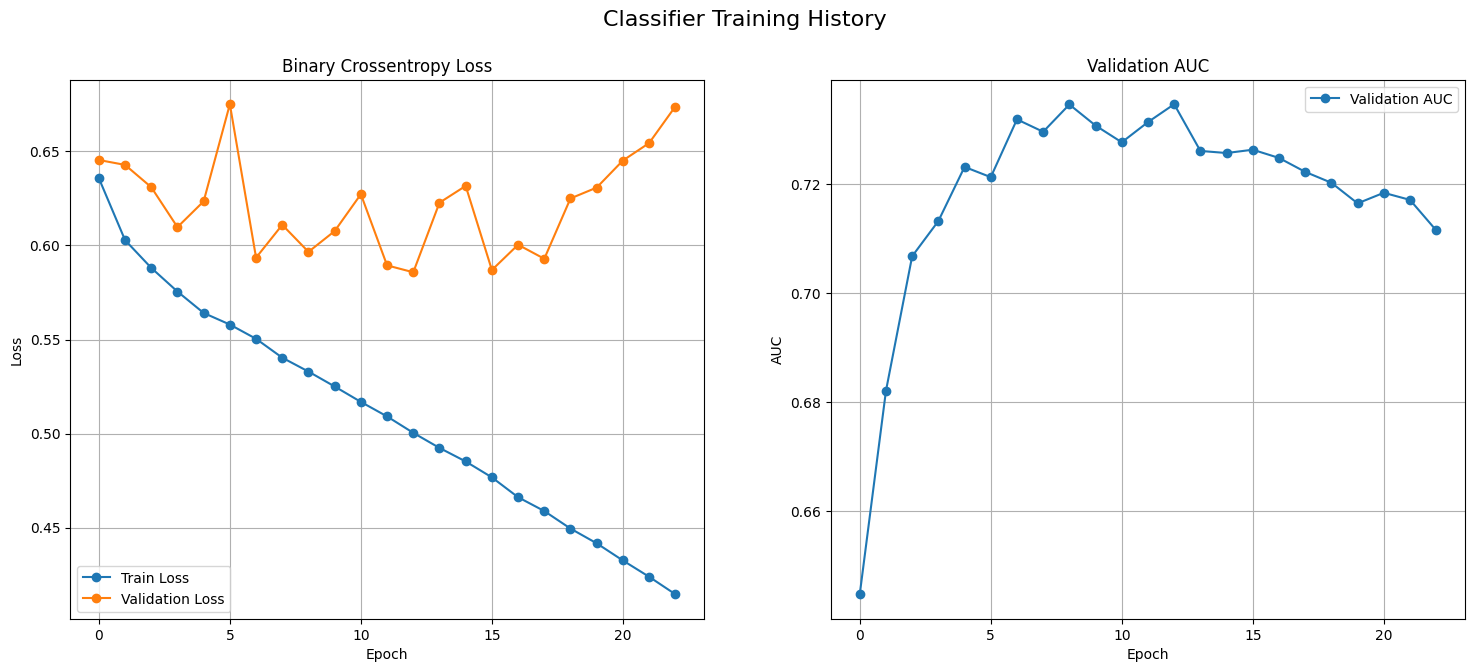

In [11]:
# BS/LR=128/1e-5

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753445617.974803    1469 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11219710530059542960
E0000 00:00:1753445618.021181    1469 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1_1/batch_normalization_2_1/Cast/ReadVariableOp.
I0000 00:00:1753445618.154329    2278 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(14212319588356899812), session_name()
I0000 00:00:1753445619.650583    2278 tpu_compile_op_common.cc:245] Compilation of 14212319588356899812 with session name  took 1.496184217s and succeeded
I0000 00:00:1753445619.654411    2278 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(14212319588356899812), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11219710530059542960", property.function_library_fingerprint = 10577014276559536661, property.mlir

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.66      0.50      0.57      2608
       Block       0.61      0.51      0.55      3474
    SoundRep       0.55      0.57      0.56      1877
     WordRep       0.53      0.50      0.51      1735
Interjection       0.89      0.61      0.72      3333

   micro avg       0.66      0.54      0.59     13027
   macro avg       0.65      0.54      0.58     13027
weighted avg       0.67      0.54      0.60     13027
 samples avg       0.63      0.56      0.56     13027


--- Generating plots for model training history... ---


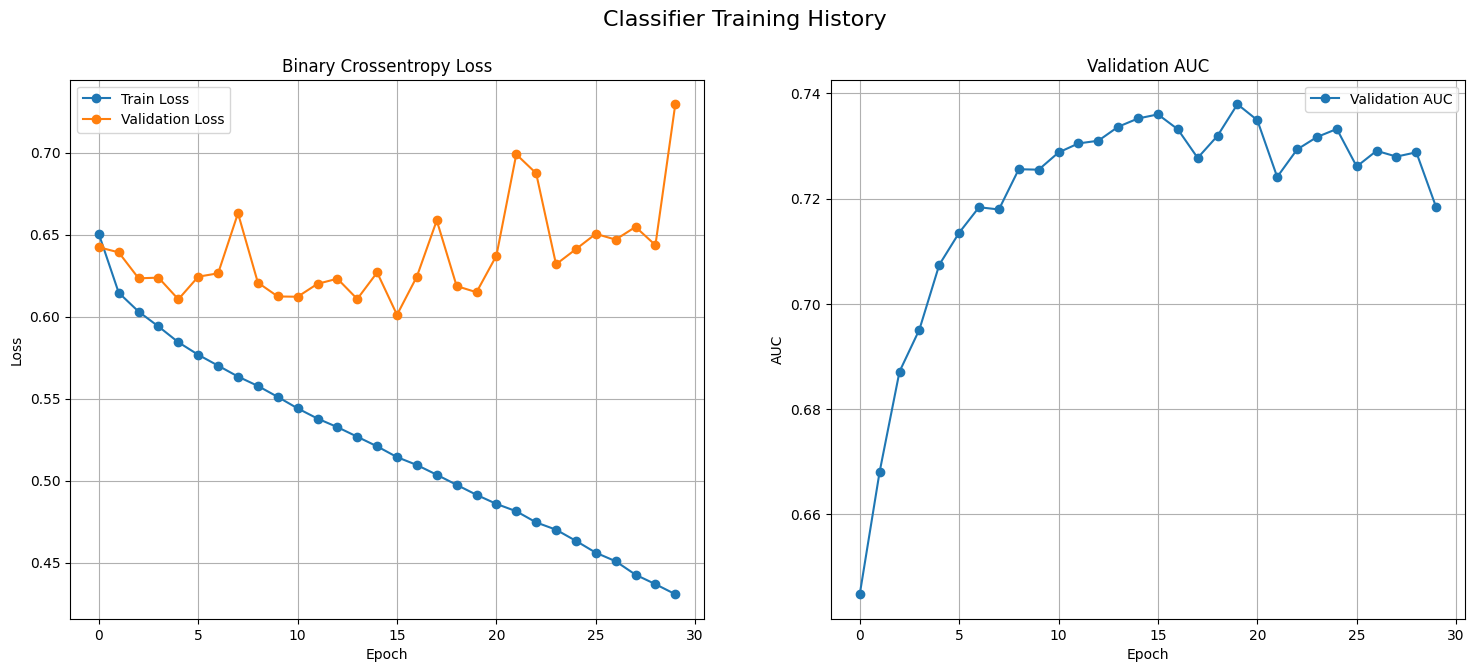

In [18]:
# BS/LR = 256/1e-5

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753446884.620815    1469 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:12238407152026586192
E0000 00:00:1753446884.658025    1469 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_2_1/batch_normalization_4_1/Cast/ReadVariableOp.
I0000 00:00:1753446884.761116    2272 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5576644647784335184), session_name()
I0000 00:00:1753446886.802213    2272 tpu_compile_op_common.cc:245] Compilation of 5576644647784335184 with session name  took 2.04104765s and succeeded
I0000 00:00:1753446886.807218    2272 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5576644647784335184), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_12238407152026586192", property.function_library_fingerprint = 12493748438505619666, property.mlir_mod

18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 294ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.81      0.21      0.33      2608
       Block       0.61      0.43      0.51      3474
    SoundRep       0.59      0.46      0.52      1877
     WordRep       0.40      0.72      0.51      1735
Interjection       0.91      0.54      0.68      3333

   micro avg       0.61      0.46      0.52     13027
   macro avg       0.66      0.47      0.51     13027
weighted avg       0.70      0.46      0.52     13027
 samples avg       0.57      0.47      0.48     13027


--- Generating plots for model training history... ---


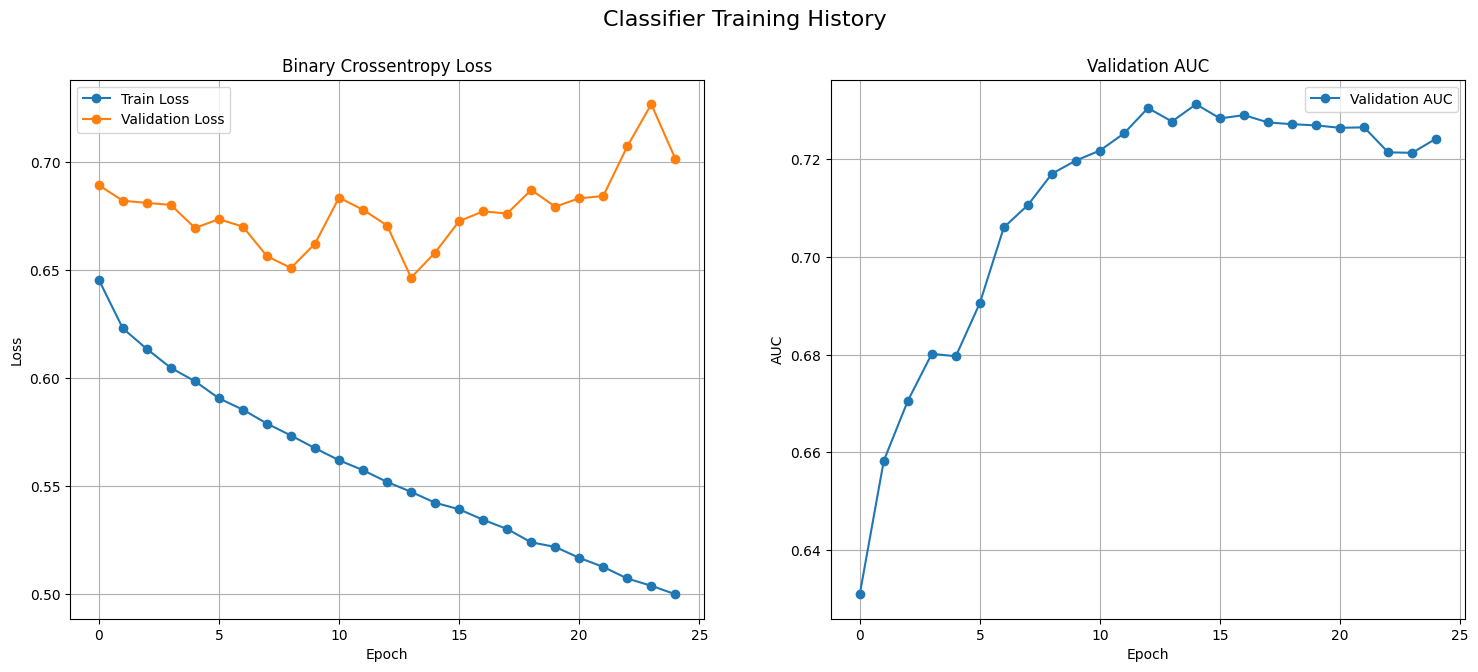

In [27]:
# BS/LR = 384/1e-5

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753451693.577018    1469 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11833524411462512995
E0000 00:00:1753451693.626117    1469 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_3_1/batch_normalization_6_1/Cast/ReadVariableOp.
I0000 00:00:1753451693.749789    2279 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2537113828621571402), session_name()
I0000 00:00:1753451695.503741    2279 tpu_compile_op_common.cc:245] Compilation of 2537113828621571402 with session name  took 1.753891124s and succeeded
I0000 00:00:1753451695.508855    2279 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2537113828621571402), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11833524411462512995", property.function_library_fingerprint = 14414243573958427353, property.mlir_mo

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.71      0.38      0.50      2608
       Block       0.66      0.26      0.38      3474
    SoundRep       0.65      0.36      0.46      1877
     WordRep       0.47      0.55      0.50      1735
Interjection       0.87      0.61      0.72      3333

   micro avg       0.68      0.43      0.53     13027
   macro avg       0.67      0.43      0.51     13027
weighted avg       0.70      0.43      0.52     13027
 samples avg       0.56      0.44      0.46     13027


--- Generating plots for model training history... ---


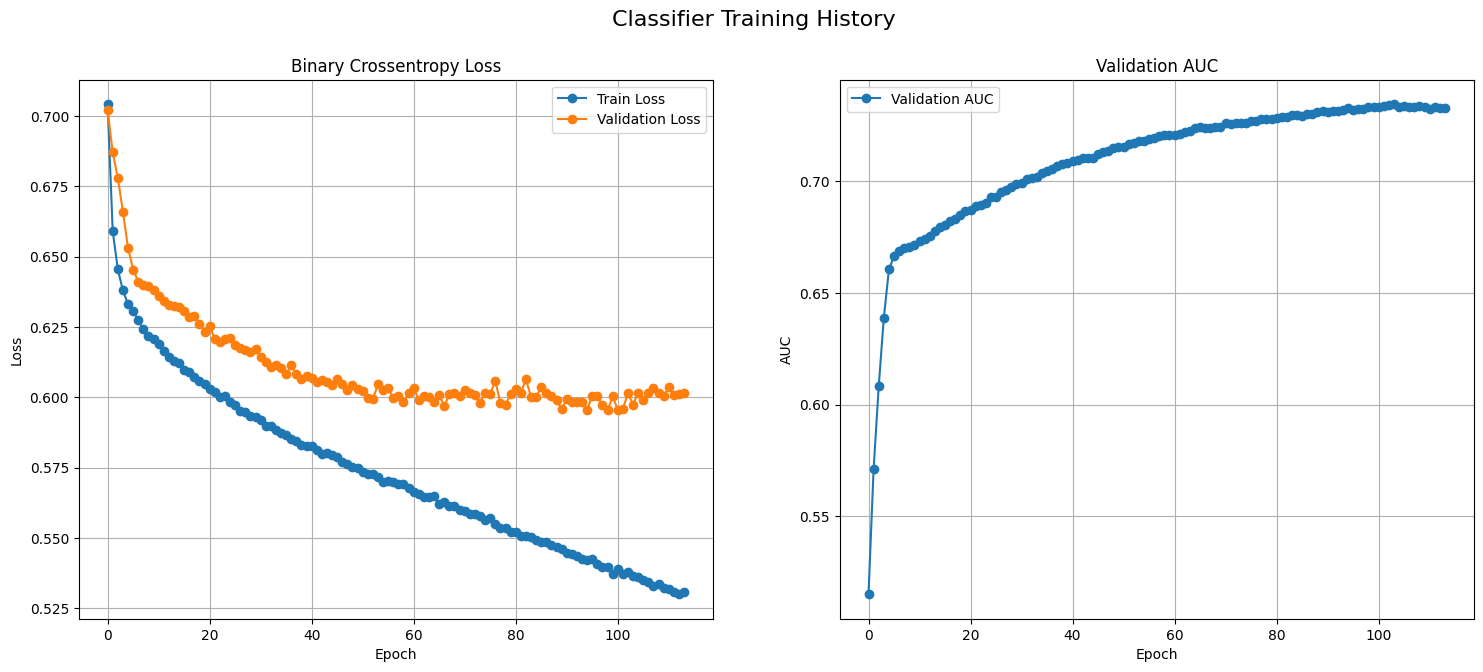

In [34]:
# BS/LR = 256/1e-6

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753453478.322242    1469 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:3537317550117984395
E0000 00:00:1753453478.372952    1469 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_4_1/batch_normalization_8_1/Cast/ReadVariableOp.
I0000 00:00:1753453478.500861    2249 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(11940493586632026191), session_name()
I0000 00:00:1753453480.097615    2249 tpu_compile_op_common.cc:245] Compilation of 11940493586632026191 with session name  took 1.596704602s and succeeded
I0000 00:00:1753453480.101748    2249 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(11940493586632026191), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_3537317550117984395", property.function_library_fingerprint = 6348460764839182903, property.mlir_mo

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.69      0.40      0.51      2608
       Block       0.61      0.50      0.55      3474
    SoundRep       0.57      0.55      0.55      1877
     WordRep       0.52      0.44      0.48      1735
Interjection       0.87      0.60      0.71      3333

   micro avg       0.66      0.50      0.57     13027
   macro avg       0.65      0.50      0.56     13027
weighted avg       0.68      0.50      0.57     13027
 samples avg       0.60      0.52      0.52     13027


--- Generating plots for model training history... ---


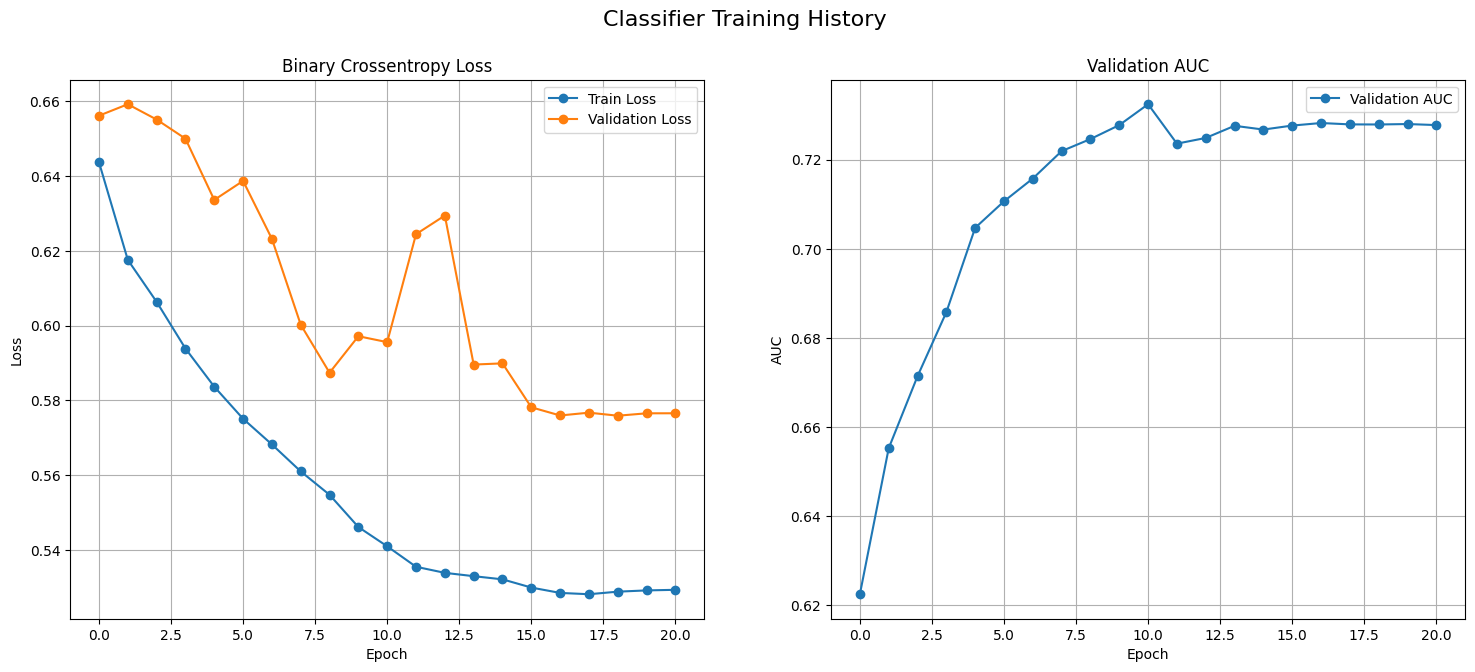

In [43]:
# BS/LR = 256/LRredu

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753454770.810614    1469 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:8740065724500621290
E0000 00:00:1753454770.861972    1469 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_6_1/batch_normalization_12_1/Cast/ReadVariableOp.
I0000 00:00:1753454770.994765    2251 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(4300850508824937826), session_name()
I0000 00:00:1753454772.733536    2251 tpu_compile_op_common.cc:245] Compilation of 4300850508824937826 with session name  took 1.738707261s and succeeded
I0000 00:00:1753454772.738932    2251 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(4300850508824937826), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_8740065724500621290", property.function_library_fingerprint = 1448544365676682738, property.mlir_modu

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.67      0.43      0.52      2608
       Block       0.63      0.39      0.48      3474
    SoundRep       0.58      0.49      0.53      1877
     WordRep       0.51      0.50      0.50      1735
Interjection       0.90      0.58      0.71      3333

   micro avg       0.67      0.48      0.56     13027
   macro avg       0.66      0.48      0.55     13027
weighted avg       0.69      0.48      0.56     13027
 samples avg       0.59      0.49      0.50     13027


--- Generating plots for model training history... ---


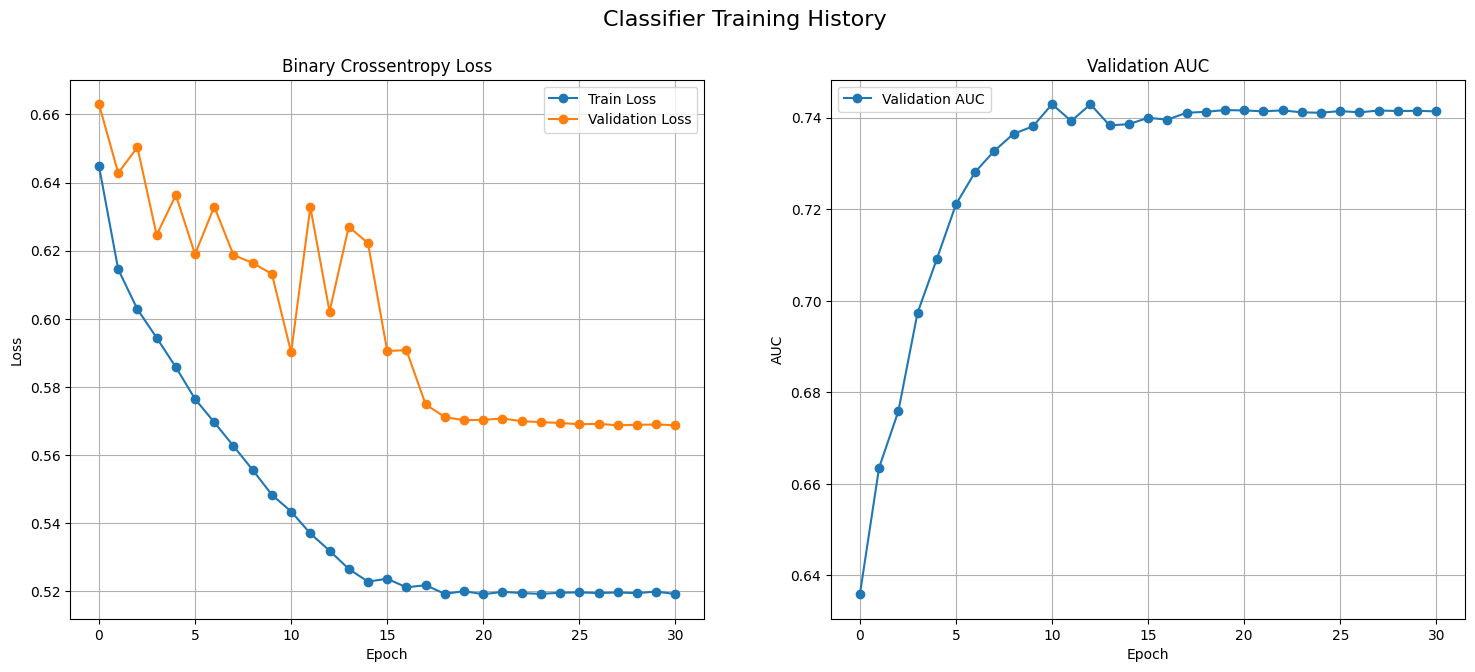

In [ ]:
# BS/LR = 256/LRredu(1e-5->8)

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753456452.529675    1469 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:3778865999852945221
E0000 00:00:1753456452.576084    1469 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_8_1/batch_normalization_16_1/Cast/ReadVariableOp.
I0000 00:00:1753456452.695908    2254 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(4692417327065654282), session_name()
I0000 00:00:1753456454.227125    2254 tpu_compile_op_common.cc:245] Compilation of 4692417327065654282 with session name  took 1.531166109s and succeeded
I0000 00:00:1753456454.232506    2254 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(4692417327065654282), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_3778865999852945221", property.function_library_fingerprint = 4626818802885597531, property.mlir_modu

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.70      0.45      0.54      2608
       Block       0.64      0.45      0.53      3474
    SoundRep       0.59      0.46      0.52      1877
     WordRep       0.52      0.48      0.50      1735
Interjection       0.85      0.67      0.75      3333

   micro avg       0.68      0.51      0.58     13027
   macro avg       0.66      0.50      0.57     13027
weighted avg       0.68      0.51      0.58     13027
 samples avg       0.62      0.53      0.54     13027


--- Generating plots for model training history... ---


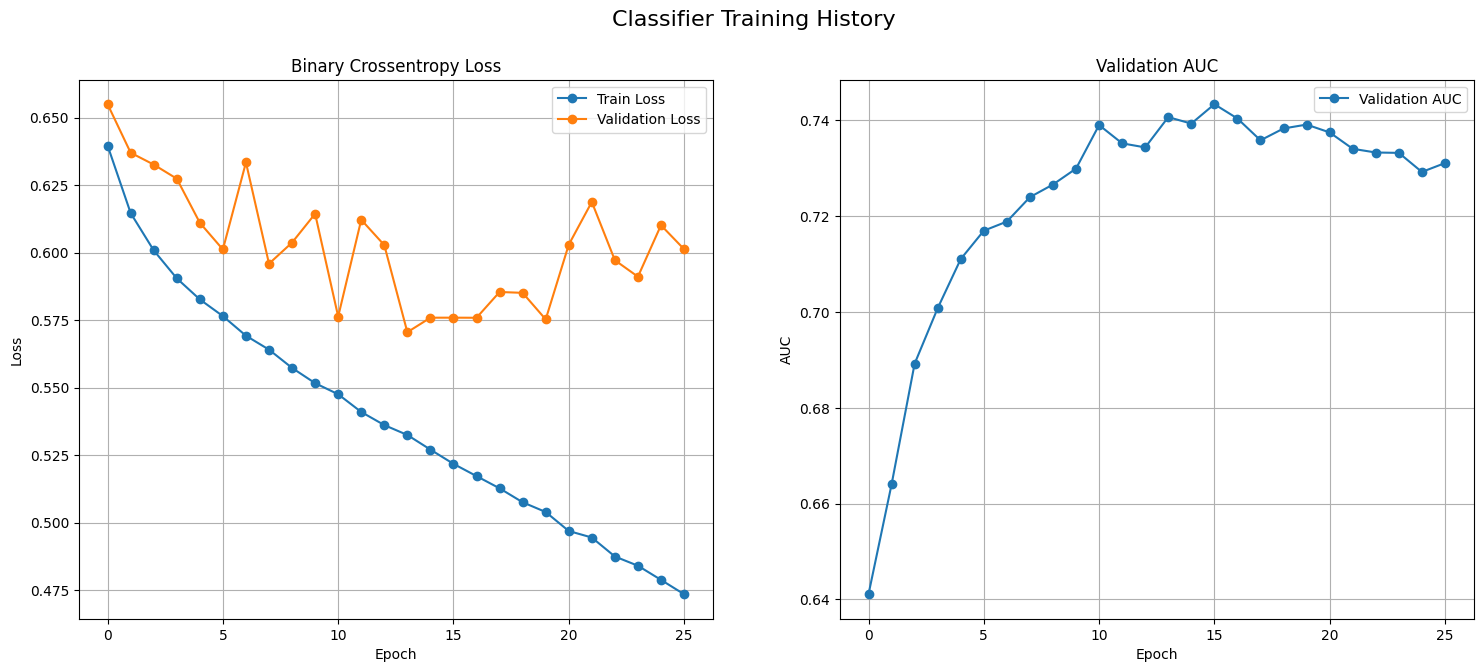

In [ ]:
# BS/LR = 256/1e-5, AdamW

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()